In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import interpolate 
import statsmodels

#import warnings #check your version of scipy/numpy/matplolib if you receive warnings (wont affect data)
#warnings.filterwarnings("ignore")

# read in pre-processed data here, the output csv of running the pre-process code
dlc_output_data = pd.read_csv('20984_var_test.csv')

#Double-check the column names to make sure they are correct 
#print (dlc_output_data.columns)

 
# get position of ladder from photoshop 
ladder_position = 91
height_of_video = 312
scale = 11 # 11 pixels = 1 cm for this video 

dlc_output_data['possum'] = 20984
dlc_output_data['condition'] = 'EB'
dlc_output_data['biosex'] = 'male'
dlc_output_data['lighting'] = 'light'
dlc_output_data['pattern'] = 1
dlc_output_data['Whiskers'] = 'yes'
dlc_output_data['Strike_Type'] = 'Correct'

########


# change everything to displacement from rung and add time in 
dlc_output_data['Snouty_disp'] = (height_of_video - dlc_output_data.Snouty - ladder_position)/scale
dlc_output_data['LFLy_disp'] = (height_of_video - dlc_output_data.LFLy - ladder_position)/scale
dlc_output_data['RFLy_disp'] = (height_of_video - dlc_output_data.RFLy - ladder_position)/scale
dlc_output_data['LHLy_disp'] = (height_of_video - dlc_output_data.LHLy - ladder_position)/scale
dlc_output_data['RHLy_disp'] = (height_of_video - dlc_output_data.RHLy - ladder_position)/scale
dlc_output_data['Tailtipy_disp'] = (height_of_video - dlc_output_data.Tailtipy - ladder_position)/scale
dlc_output_data['RFLx'] = dlc_output_data.RFLx / scale
dlc_output_data['Snoutx'] = dlc_output_data.Snoutx / scale
dlc_output_data['Tailtipx'] = dlc_output_data.Tailtipx / scale
dlc_output_data['LFLx'] = dlc_output_data.LFLx / scale
dlc_output_data['RHLx'] = dlc_output_data.RHLx / scale
dlc_output_data['LHLx'] = dlc_output_data.LHLx / scale

dlc_output_data['Time'] = ((dlc_output_data.coords / 120)*2) # You can adjust for our own framerate here

print ('numpy version:',np.__version__)
print ('seaborn version:',sns.__version__)
print ('pandas version:', pd.__version__)
print ('matplotlib version', matplotlib.__version__)
#print ('statsmodels version', statsmodels.tools.print_version)

numpy version: 1.19.2
seaborn version: 0.11.0
pandas version: 1.1.3
matplotlib version 3.3.2


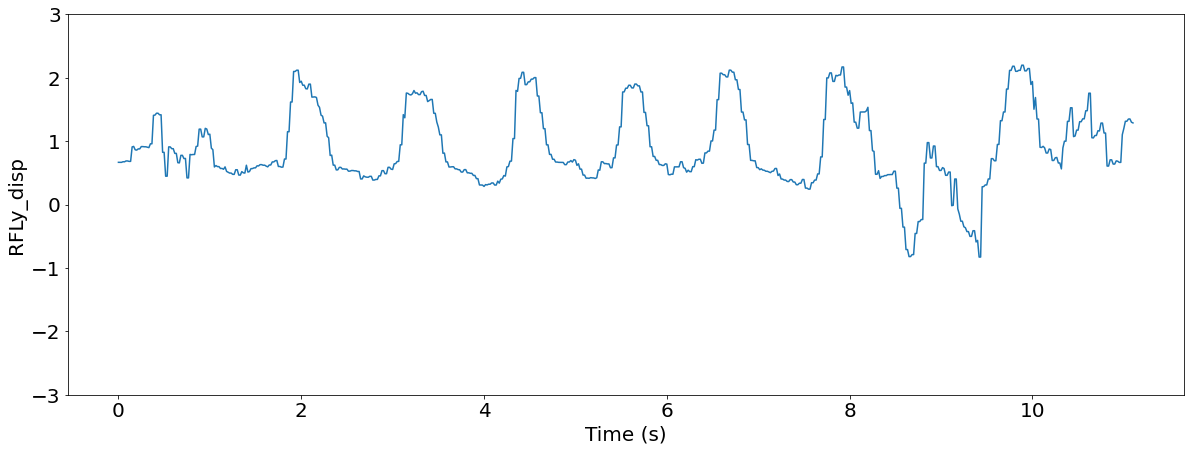

In [2]:
# Plot a test figure
plt.rcParams['figure.figsize']=(20,7)
sns.lineplot(x="Time", y="RFLy_disp", data=dlc_output_data)
plt.ylim(-3, 3)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('RFLy_disp', fontsize=20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.savefig('star_all_fl.pdf') # You can save the figure here if you'd like

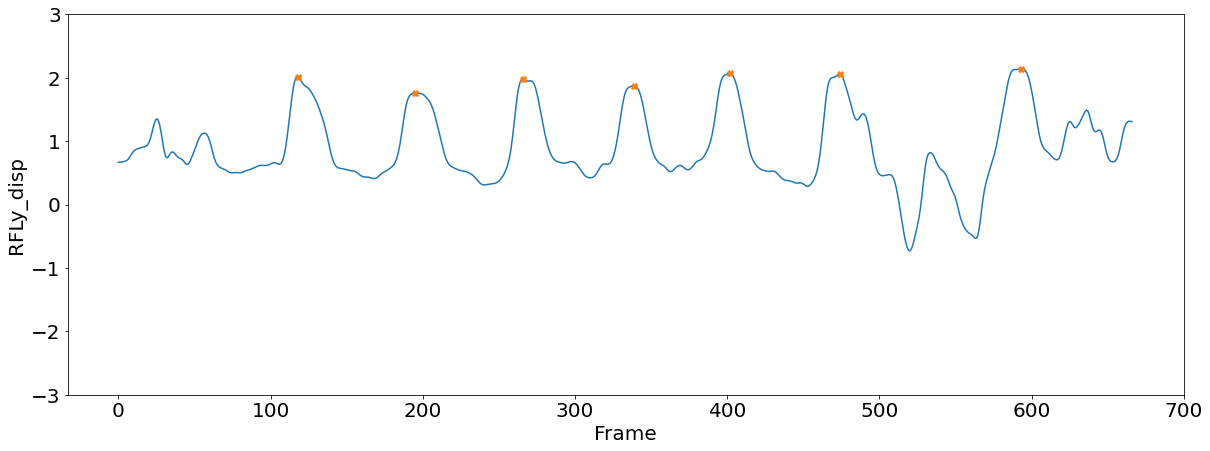

<Figure size 1440x504 with 0 Axes>

In [3]:
# Smooth the data with a gaussian filter to make finding the peaks easier 
from scipy.ndimage import gaussian_filter1d
data = dlc_output_data
data.columns
rfl = data.RFLy_disp
rfl_blur = gaussian_filter1d(rfl,sigma = 2)

rfl_blur = rfl_blur #for the misses use rfl_blur * (-1)


# Find the peaks and plot them 
from scipy.signal import find_peaks
x = rfl_blur 
peaks, _ = find_peaks(x, height = 1.5,distance = 25)
plt.plot(x)
plt.plot(peaks, x[peaks], "X")
plt.xticks(np.arange(0, 800, step=100)) # you can better adjust the axis to your liking
plt.ylim(-3, 3)
plt.xlabel('Frame', fontsize=20)
plt.ylabel('RFLy_disp', fontsize=20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.savefig('Test_Forelimb_Peaks.pdf') # You can save the figure here if you'd like
plt.show()

plt.savefig('star_all_fl_peaks.pdf')

In [4]:
# This is for method 2, which finds where threshold crosses are..not neccesary to run commented code
data['rflblur'] = rfl_blur
data['rflblur'] = data.rflblur.round(0)

def chunk_strikes2(dataset,threshold):
    current_frame = 0
    data2 = pd.DataFrame(columns = dataset.columns)  
    for index, row in dataset.iterrows(): 
        if (threshold - .5) < row['rflblur'] < (threshold + .3):
            current_frame += 1 
            data2.loc[index] = row
            #print (index)         
    return data2


# IF METHOD 2 ###
# Get the indexes of the above values,  it is only useful for chunkstrikes2
#c = list(b.index.values)
#c_frame = b.coords
#c_frame

## IF YOU CHOOSE METHOD 2 ####

# Run the chunk strikes function and get rid of adjacent points and then plot the threshold crosses
#a = chunk_strikes2(data,0)
#a['frame_diff'] = a['coords'] - a['coords'].shift()
#b = a[a['frame_diff'] != 1.0]

#https://python-graph-gallery.com/122-multiple-lines-chart/
#plt.rcParams['figure.figsize']=(18,6)
#plt.plot( 'RFLx', 'rflblur', data=b, marker='o', markerfacecolor='blue', markersize=15, color='skyblue', linewidth=0)
#plt.plot('RFLx', 'rflblur', data=data, marker='', color='olive', linewidth=2)
#plt.xticks(np.arange(0, 8, step=.5))
#plt.legend()


# METHOD 1 ##
#use the peaks method to get a list of peaks 
list_peaks = peaks.tolist()

# Take a look at the graph and this list, and then select what you want to remove 
list_peaks # or c_frame, depending on method 

[118, 195, 266, 339, 402, 474, 593]

# In the next step, you can remove the peaks with bad tracking (or strikes you do not want to analyze)
# AND/OR
# You can keep all strikes, removing just time-points below the chosen p-cutoff, and interpolate the missing data

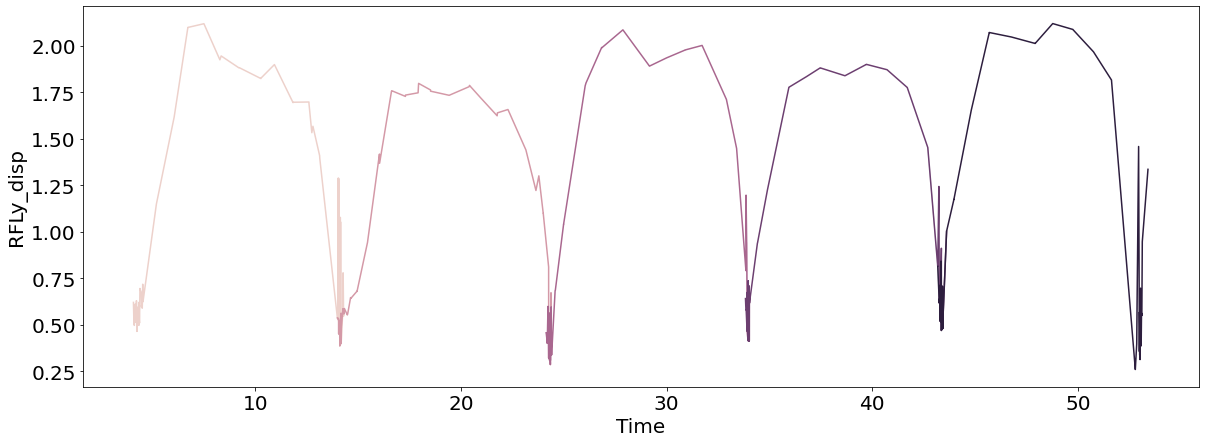

In [5]:
# Remove the peaks you dont want 
list_peaks.remove(474)
list_peaks.remove(593)


# make a new DataFrame based on data, but containing only the data range we want
d = pd.DataFrame(columns = data.columns)
for indice in list_peaks: 
    f = data.loc[indice - 49: indice + 50]
    d = d.append(f)
    
# https://stackoverflow.com/questions/48346156/python-create-column-of-repeated-values-that-matches-length-of-dataframe
# ok now we want to group each strike 
from math import floor
val = 0 
d['strike'] = [val + floor(i / 100) for i in range(len(d.index))] 
listit = list(range(100))


# https://stackoverflow.com/questions/46063428/filling-a-pandas-dataframe-with-repeating-values
# now we want to add x_values so we can align each strike 
d['x_vals'] = np.tile(listit,len(list_peaks)) #or use c_frame if using other method 


# plot each strike - you should see holes where you removed those peaks from the list 
sns.lineplot(x="RFLx", y="RFLy_disp", hue="strike",data=d, legend = False)

plt.xlabel('Time', fontsize=20)
plt.ylabel('RFLy_disp', fontsize=20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)
#plt.savefig('Test_Forelimb_For_Analysis.pdf') # You can save the figure here if you'd like


In [6]:
# Choose a p-cutoff value. This prints the datapoints and indices of those points that fall below the cutoff. 
strikes = d.groupby('strike')
strike_groups = strikes.groups.keys()
p_cutoff = 0.5 
index_list = []

for strike in strike_groups:
    this_strike = d.loc[d.strike == strike].copy()
    for value in this_strike.RFL_Likelihood.values:
        if value < p_cutoff: 
            this_array = list(this_strike.RFL_Likelihood.values)
            this_index = this_array.index(value)
            index_list.append((strike,this_index))
            print('strike', strike ,'','index',this_index,'','L_hood',value.round(2))
#        print(strike)
#        if value < p_cutoff:
#            print(strike,value)

In [7]:
# If your strikes have low p values you can use interpolation (from scipy package)

# Interpolation is applied to all strikes, affecting only datapoints below the p-cutoff
interp_d_list = []
for strike in strike_groups:
    this_strike = d.loc[d.strike == strike].copy()
    # this creates two dataframes
    over_p_cutoff = this_strike.loc[this_strike.RFL_Likelihood > p_cutoff]
    under_p_cutoff = this_strike.loc[this_strike.RFL_Likelihood <= p_cutoff]
    
    # Interpolation happens here
    x_old = over_p_cutoff.x_vals.values
    x_new = np.arange(x_old[0],x_old[-1] + 1,1)

    y_old = over_p_cutoff.RFLy_disp.values
        
    f = interpolate.interp1d(x_old, y_old, kind='linear') # kind can also be 'cubic'. Check plots below for best results

    y_new = f(x_new)
    
    this_strike['RFLy_disp_interp'] = y_new
    
    interp_d_list.append(this_strike)
    

interp_d = pd.concat(interp_d_list)

# Note that we interpolated for the Right Forelimb in this example. 
# This code can be easily adapted to interpolate over any/every body part tracker.

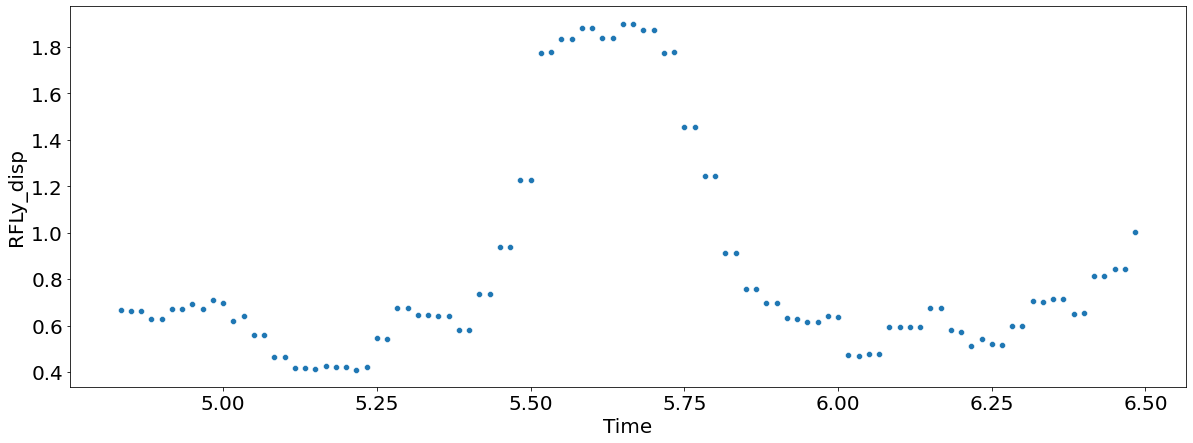

In [8]:
# Check that your interp worked by first plotting our strike with bad points (no p-cutoff used): 
this_strike = interp_d.loc[interp_d.strike == 3].copy()
sns.scatterplot(x="Time", y="RFLy_disp",data=this_strike, legend = False)
plt.xlabel('Time', fontsize=20)
plt.ylabel('RFLy_disp', fontsize=20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)

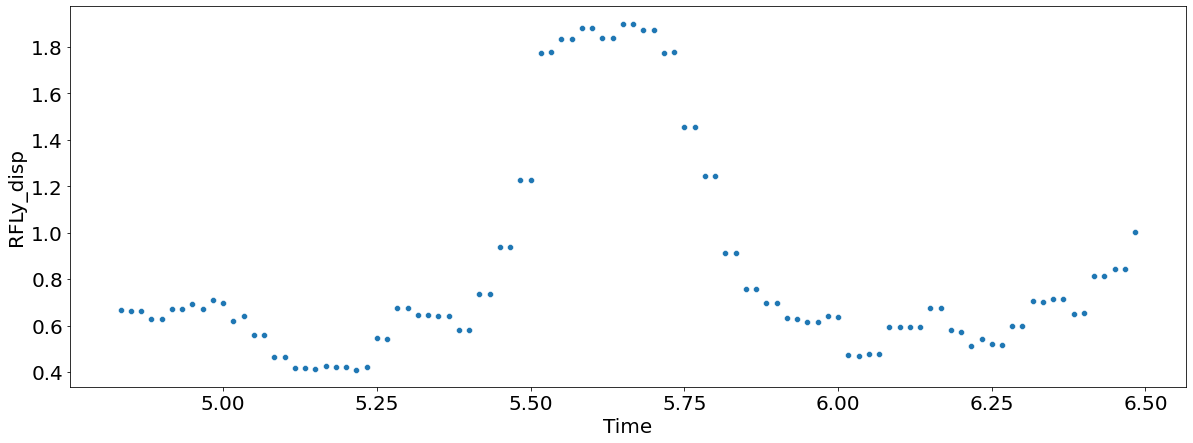

In [9]:
# And then plotting the same strike using the interpolated values intead
this_strike = interp_d.loc[interp_d.strike == 3].copy()
sns.scatterplot(x="Time", y="RFLy_disp_interp",data=this_strike, legend = False)
plt.xlabel('Time', fontsize=20)
plt.ylabel('RFLy_disp', fontsize=20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)

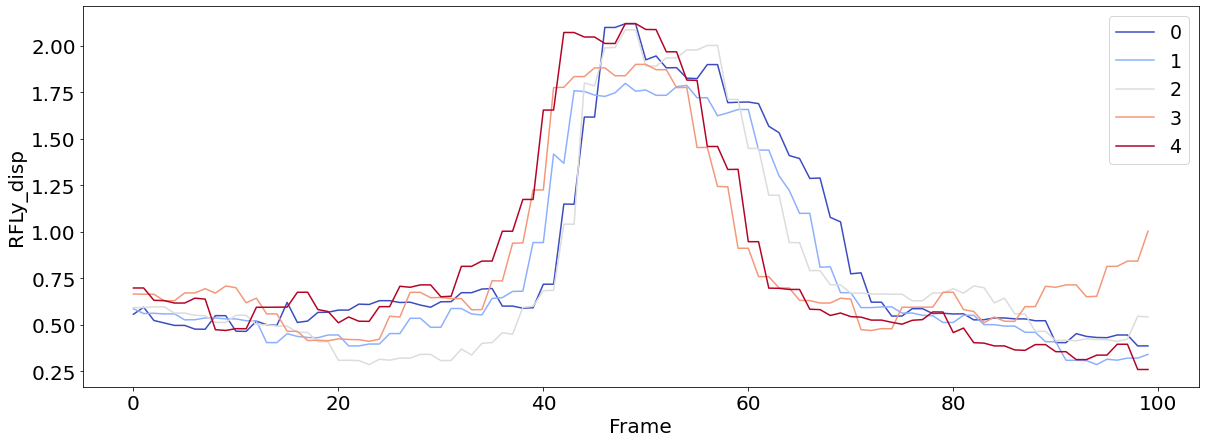

In [10]:
# this sections aligns all peaks by x values by shifting, subtracting, and then using .cumsum() 

def func(single_group_data):
    x_displacement = single_group_data['RFLx'].max() - single_group_data['RFLx'].min()
    x_disp = round(x_displacement,0)
    #single_group_data['RFLx_align'] = np.linspace(0,x_disp,num = len(single_group_data))# for evevnly spaced use this
    single_group_data['RFLx_diff'] = single_group_data['RFLx'] - single_group_data['RFLx'].shift()
    single_group_data['RFLx_cumsum'] = single_group_data.RFLx_diff.cumsum()
    
    
    # now this should do the x component for snout 
    single_group_data['Snoutx_diff'] = single_group_data['Snoutx'] - single_group_data['Snoutx'].shift()
    single_group_data['Snoutx_cumsum'] = single_group_data.Snoutx_diff.cumsum()
    
    #LFL, RHL, LHL, Tail:
    single_group_data['LFLx_diff'] = single_group_data['LFLx'] - single_group_data['LFLx'].shift()
    single_group_data['LFLx_cumsum'] = single_group_data.LFLx_diff.cumsum()
    
    single_group_data['RHLx_diff'] = single_group_data['RHLx'] - single_group_data['RHLx'].shift()
    single_group_data['RHLx_cumsum'] = single_group_data.RHLx_diff.cumsum()
    
    single_group_data['LHLx_diff'] = single_group_data['LHLx'] - single_group_data['LHLx'].shift()
    single_group_data['LHLx_cumsum'] = single_group_data.LHLx_diff.cumsum()
    
    single_group_data['Tailtipx_diff'] = single_group_data['Tailtipx'] - single_group_data['Tailtipx'].shift()
    single_group_data['Tailtipx_cumsum'] = single_group_data.Tailtipx_diff.cumsum()
    
    return single_group_data

# create vectors if applicable
d_rflx_align = interp_d.groupby('strike').apply(func)
d_rflx_align['RFL_vector'] = (d_rflx_align.RFLx_cumsum**2) + (d_rflx_align.RFLy_disp**2)
d_rflx_align['RFL_vector'] = (d_rflx_align.RFL_vector**.5)


# now plot the lined-up peaks separate
sns.lineplot(x="x_vals", y="RFLy_disp_interp",hue = 'strike',data=d_rflx_align,palette='coolwarm')
plt.xlabel('Frame', fontsize=20)
plt.ylabel('RFLy_disp', fontsize=20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)

plt.legend(loc=1, prop={'size': 19})

#plt.savefig('Test_Forelimb_Aligned.pdf') 
plt.savefig('star_all_stacked.pdf')# You can save the figure here if you'd like

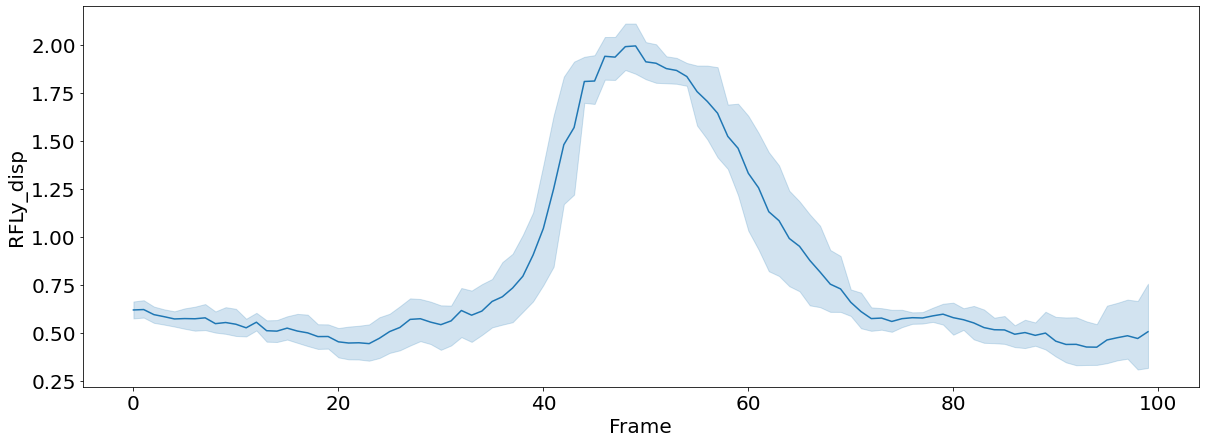

In [11]:
# and plot the combined waveform 
sns.lineplot(x="x_vals", y="RFLy_disp_interp",data=d_rflx_align)
plt.xlabel('Frame', fontsize=20)
plt.ylabel('RFLy_disp', fontsize=20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)
#plt.savefig('Test_Forelimb_Average.pdf') # You can save the figure here if you'd like

In [12]:
# save your data: Possum_number_lighting_pattern_correctormiss
d_rflx_align.to_csv('Will_20984_Light_Var1_correct_date.csv',index=False)  